In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow, paths
from src.data import Dataset

In [ ]:
import umap
import umap.plot
import numpy as np
from vectorizers import NgramVectorizer

In [ ]:
breweries_ds = Dataset.load("breweries_by_reviewers")
breweries = breweries_ds.data
len(breweries)

## Embed the data

We are going to vectorize our data and look at the number of categorical values they have in common.  A useful thing to do here is to require each row to have a minimum support before being included.  Filtering this early, will ensure indices line up later on.

We probably want to remove any brewery that has only a few reviewers.  This threshold can be based on intuition or by examining the distribution of reviews per brewery.

In [ ]:
breweries.num_reviewers.value_counts().sort_index().plot.hist(bins=20);

Let's say we need 100 reviewers to be truly popular.

In [ ]:
popular_breweries = breweries[breweries.num_reviewers>100].reset_index(drop=True)
len(popular_breweries)

This next step turns the list of reviewers into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.

We use `min_document_occurrences=10` in our NgramVectorizer to only count reviewers who have reviewed at least 10 beers. 


In [ ]:
brewery_by_authors_vectorizer = NgramVectorizer(min_document_occurrences=10)
brewery_by_authors = brewery_by_authors_vectorizer.fit_transform(popular_breweries.review_profilename_list)
brewery_by_authors

Now we reduce the dimension of this data.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Thing of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [ ]:
%%time
brewery_by_authors_model = umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard', min_dist=0.1,
                                  unique=True, random_state=42).fit(brewery_by_authors.todense())

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'brewery_by_reviewer_jaccard'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
umap_plot = umap.plot.points(brewery_by_authors_model,
                             labels=np.log(popular_breweries.num_reviewers.values),
                             theme='fire',
                             show_legend=False);
umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

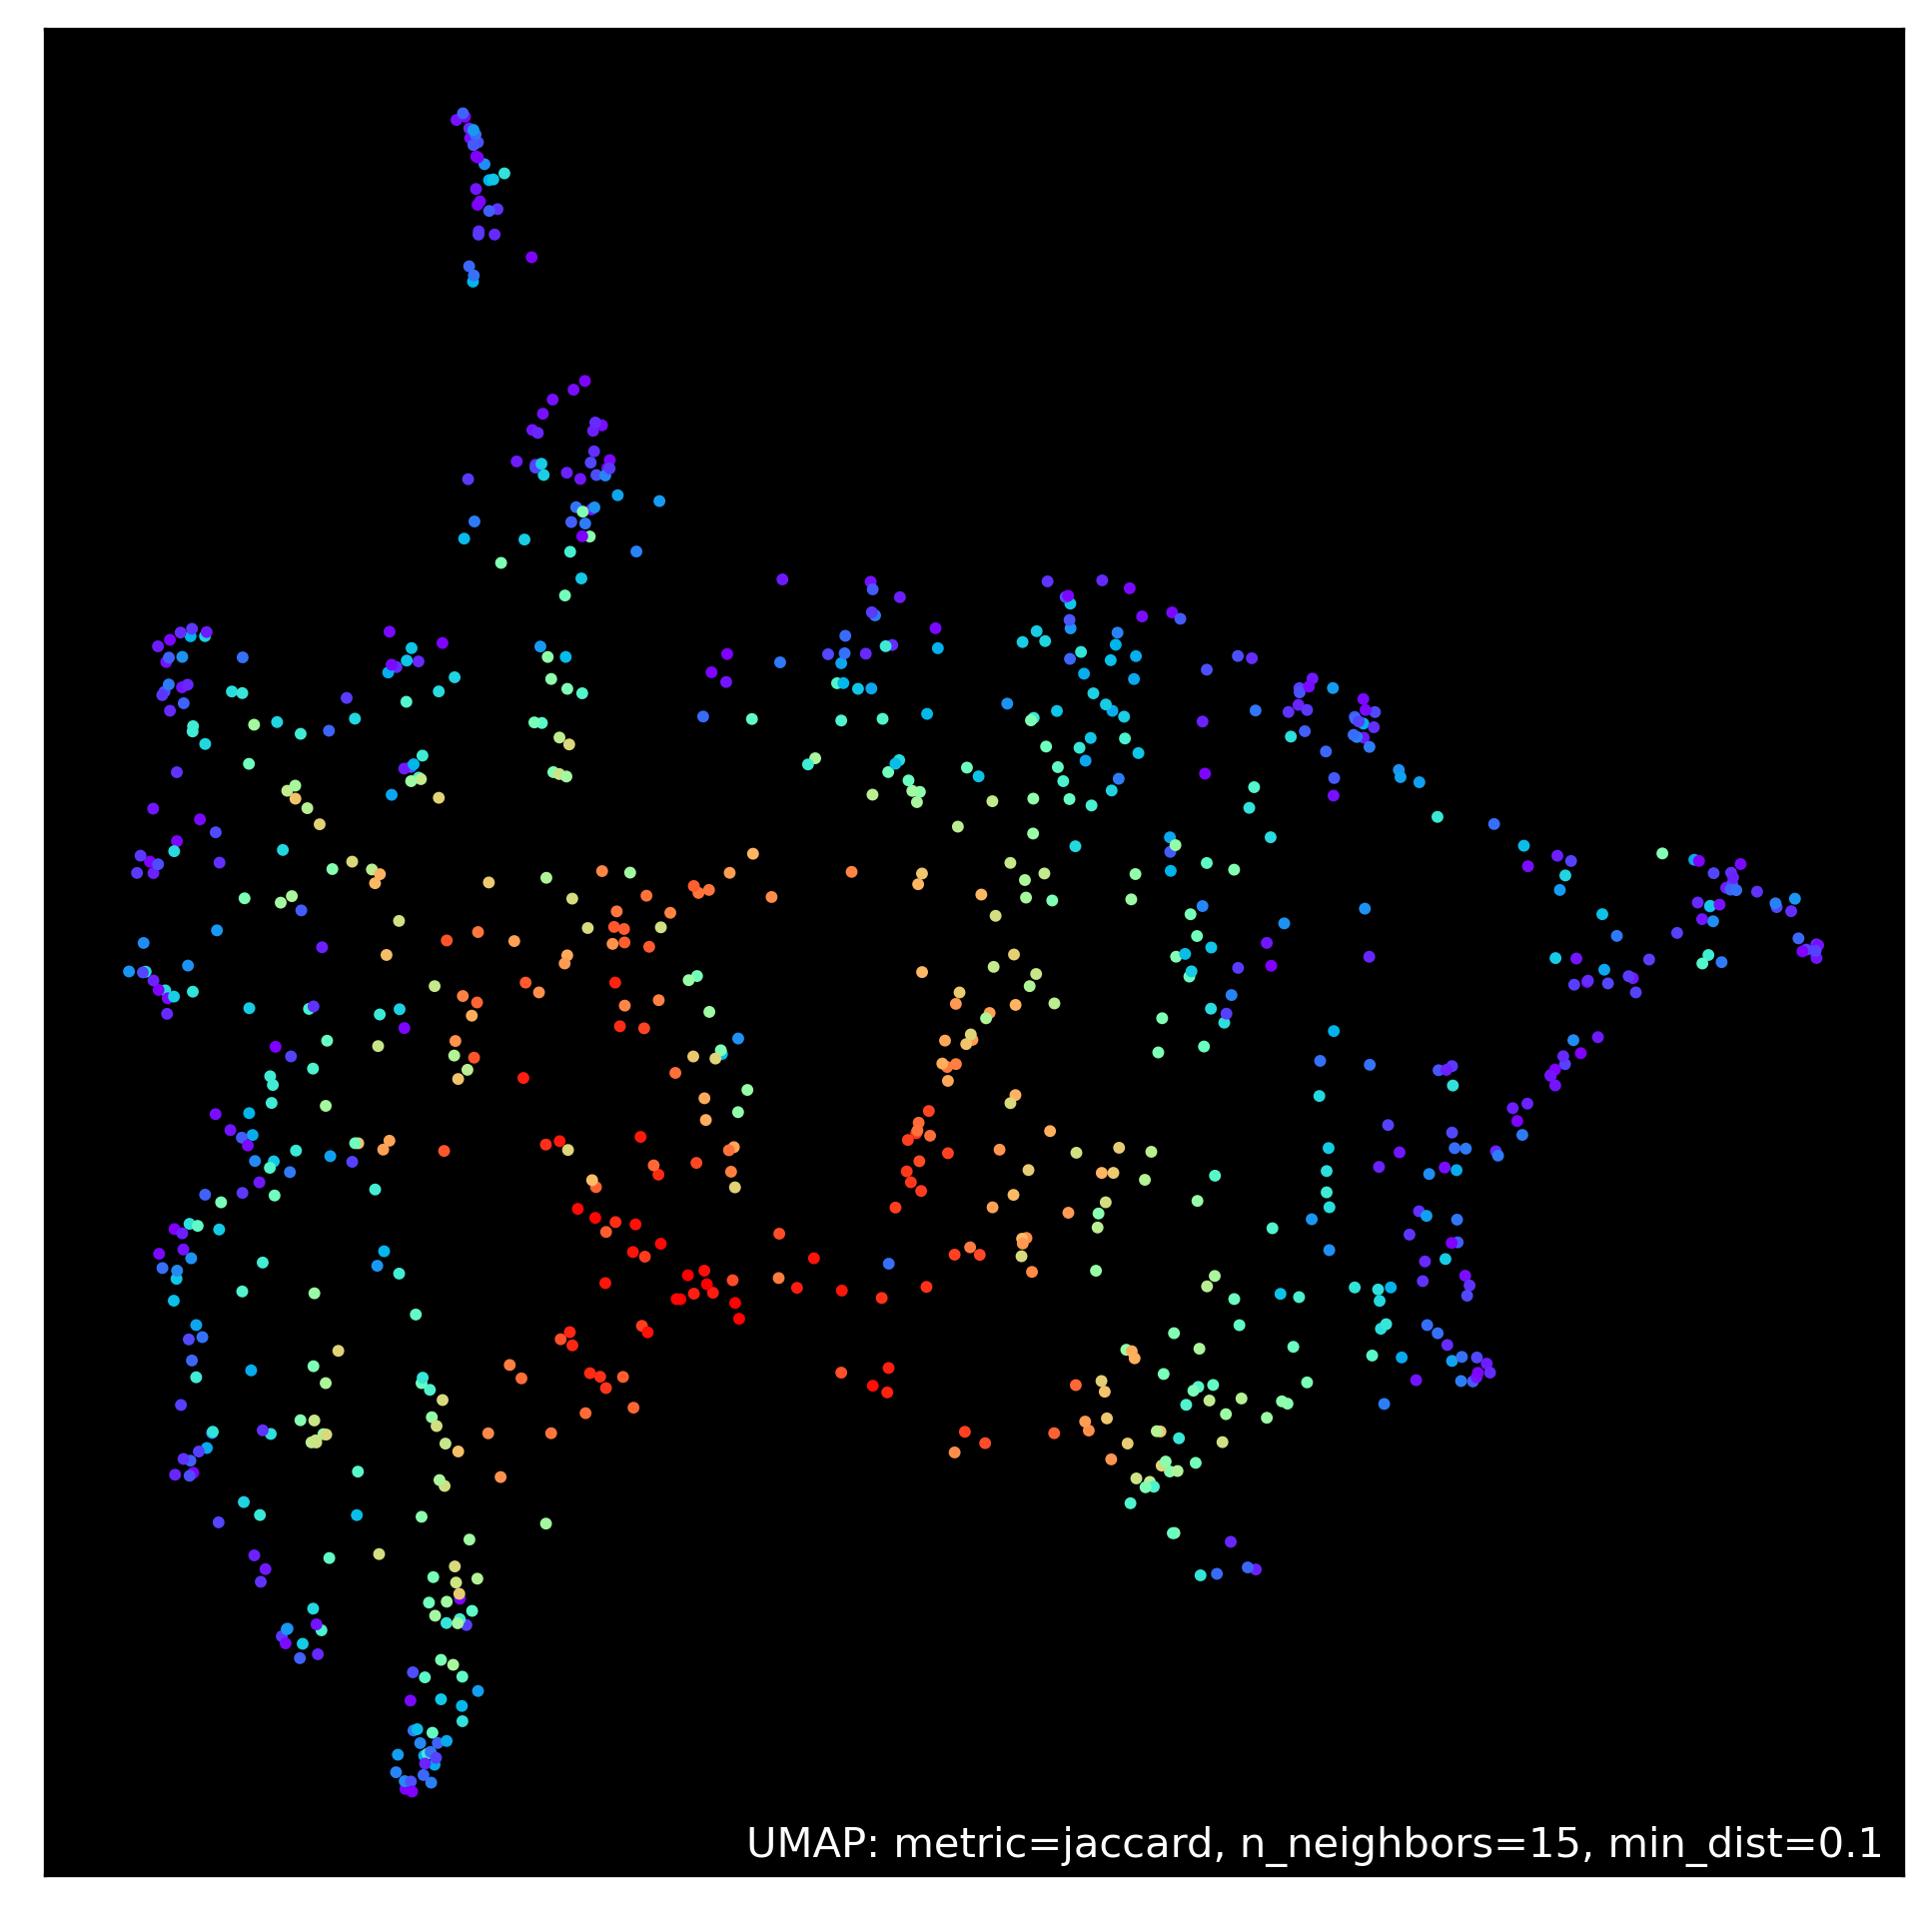

... and now for an interactive plot with mouseover.

In [ ]:
hover_df = popular_breweries['brewery_name beer_style beer_abv num_reviewers review_overall'.split()]
f = umap.plot.interactive(brewery_by_authors_model, labels=np.log(popular_breweries.num_reviewers.values), 
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)

Not surprisingly when you embed breweries by their reviewers you end up creating a massive hub in the center where the very popular breweries have been reviewed by everyone.  Then you fragment into the outskirts where less popular breweries tend to be reviewed by locals, thus clustering by geographic regions.